# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [2]:
#Load your data into a pandas dataframe here
df = pd.read_csv(
    "household_power_clean.zip",
    compression="zip",
    parse_dates=["Datetime"]
)

In [3]:
#convert datetime to epoch/unix time
df["unix"] = df["Datetime"].astype("int64") // 10**9

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph (prediction horizon) represents how far into the future the model predicts the target variable.  
mu is a forgetting factor that determines how much influence older data points have on the regression model. Values closer to 1 retain historical influence, while smaller values emphasize recent data.


**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [4]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

# 5 minutes = 300 seconds
ph = 300

# data resolution = 1 minute (60 seconds)
ph_index = int(ph / 60)

mu = 0.9


#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: The weight will be 0.9 raised to the power of 4999, which is effectively zero. This means very old data has negligible influence on later predictions, allowing the model to adapt to recent patterns.


**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [6]:
# At every iteration of the for loop a new data sample is acquired
for i in range(ph_index + 1, n_s + 1):
    ts_tmp = ts.iloc[0:i - ph_index]
    ys_tmp = ys.iloc[0:i - ph_index]
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** (ns - k)
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    tp = ts.iloc[i - 1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - ph_index - 1] = tp
    yp_pred[i - ph_index - 1] = yp


Now let's visualize the results from our model.

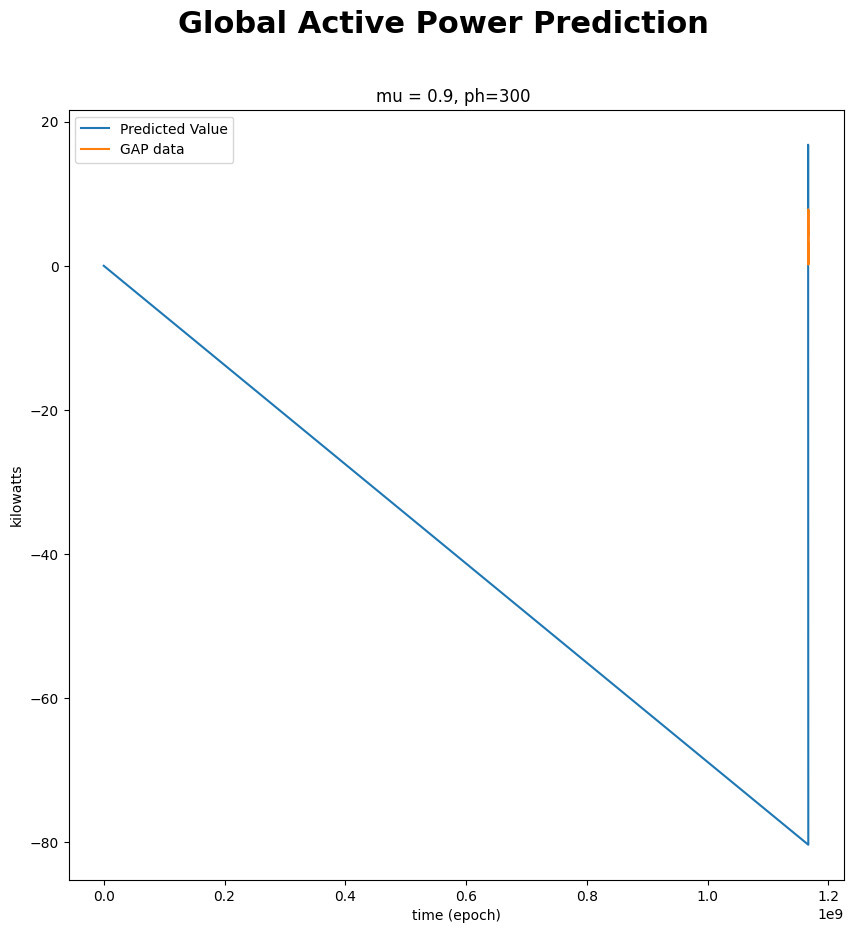

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

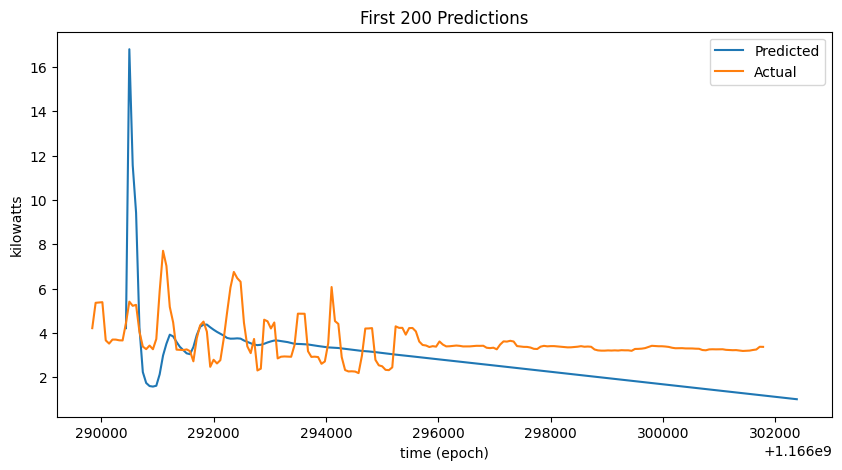

In [8]:
#Plot first 200 data points/predictions
plt.figure(figsize=(10,5))
plt.plot(tp_pred[:200], yp_pred[:200], label="Predicted")
plt.plot(ts.iloc[:200,0], ys.iloc[:200,0], label="Actual")
plt.title("First 200 Predictions")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


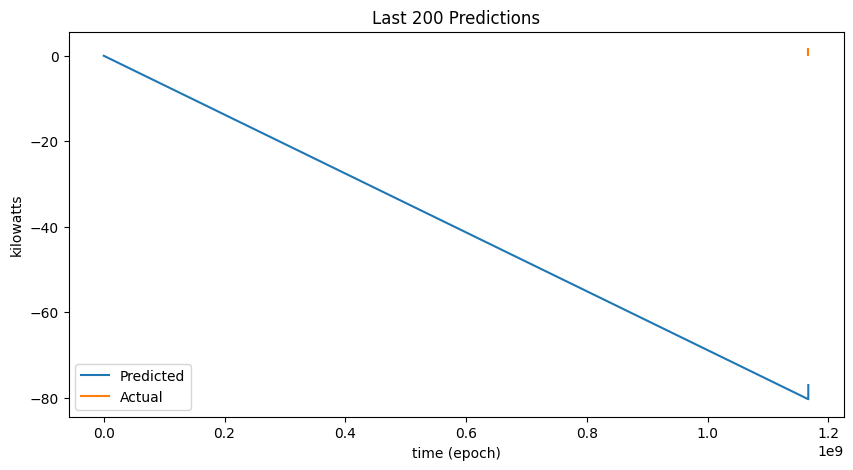

In [9]:
#Plot last 200 data points/predictions
plt.figure(figsize=(10,5))
plt.plot(tp_pred[-200:], yp_pred[-200:], label="Predicted")
plt.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label="Actual")
plt.title("Last 200 Predictions")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


In [11]:
#Calculate MSE of predictions

from sklearn.metrics import mean_squared_error as mse

print(
    "MSE is",
    mse(
        ys["Global_active_power"][ph_index:5000+ph_index-1],
        yp_pred
    )
)


MSE is 2147.9748000634436


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model captures the overall trend of Global Active Power but smooths out short-term fluctuations. Early predictions show higher error due to limited training data, while later predictions improve as more data becomes available. The MSE quantifies the average squared prediction error and confirms that prediction accuracy improves as the model accumulates more historical data.


**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [15]:
#Re-run prediction code for mu = 1
mu = 1

# reinitialize prediction arrays
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

for i in range(ph_index + 1, n_s + 1):
    ts_tmp = ts.iloc[0:i - ph_index]
    ys_tmp = ys.iloc[0:i - ph_index]
    ns = len(ys_tmp)

    # all weights equal since mu = 1
    weights = np.ones(ns)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    tp = ts.iloc[i - 1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - ph_index - 1] = tp
    yp_pred[i - ph_index - 1] = yp


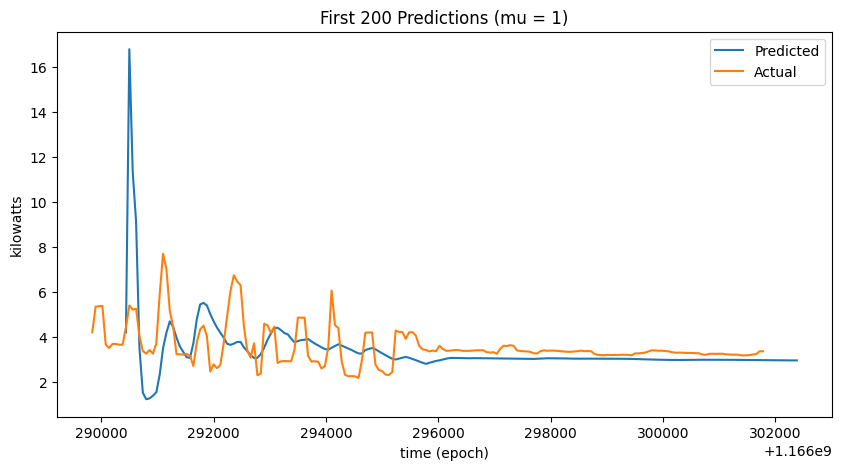

In [17]:
#Plot first 200 data points/predictions for mu = 1
plt.figure(figsize=(10,5))
plt.plot(tp_pred[:200], yp_pred[:200], label="Predicted")
plt.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label="Actual")
plt.title("First 200 Predictions (mu = 1)")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


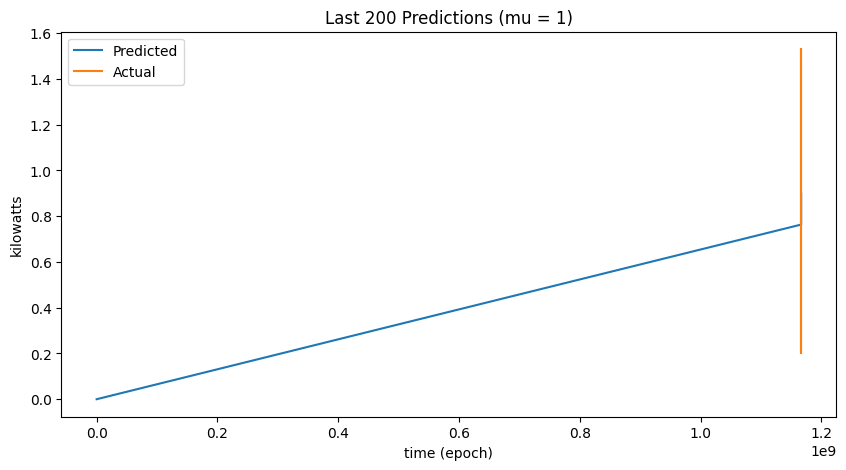

In [18]:
#Plot last 200 data points/predictions for mu = 1
plt.figure(figsize=(10,5))
plt.plot(tp_pred[-200:], yp_pred[-200:], label="Predicted")
plt.plot(ts.iloc[n_s-200:n_s, 0], ys.iloc[n_s-200:n_s, 0], label="Actual")
plt.title("Last 200 Predictions (mu = 1)")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


In [19]:
#Calculate MSE of predictions for mu = 1
print(
    "MSE for mu = 1 is",
    mse(
        ys["Global_active_power"][ph_index:5000 + ph_index - 1],
        yp_pred
    )
)


MSE for mu = 1 is 1.4920955657639485


In [21]:
#Re-run prediction code for mu = 0.01
mu = 0.01

# reinitialize prediction arrays
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

for i in range(ph_index + 1, n_s + 1):
    ts_tmp = ts.iloc[0:i - ph_index]
    ys_tmp = ys.iloc[0:i - ph_index]
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** (ns - k)
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    tp = ts.iloc[i - 1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - ph_index - 1] = tp
    yp_pred[i - ph_index - 1] = yp


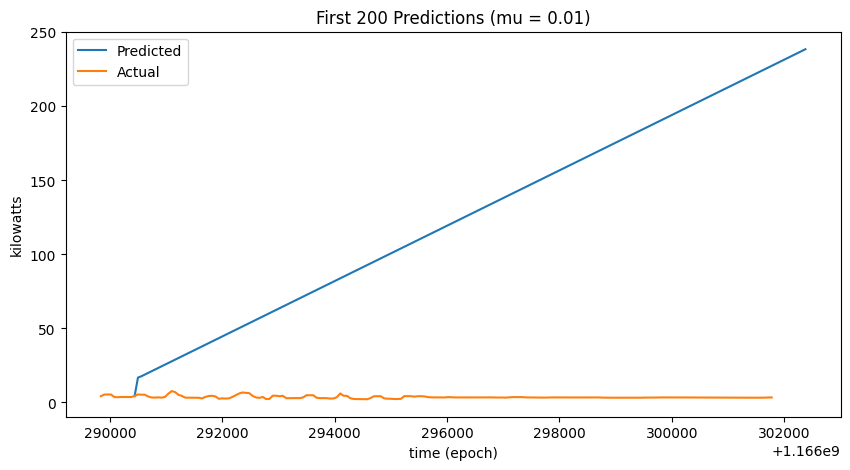

In [22]:
#Plot first 200 data points/predictions for mu = 0.01
plt.figure(figsize=(10,5))
plt.plot(tp_pred[:200], yp_pred[:200], label="Predicted")
plt.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label="Actual")
plt.title("First 200 Predictions (mu = 0.01)")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


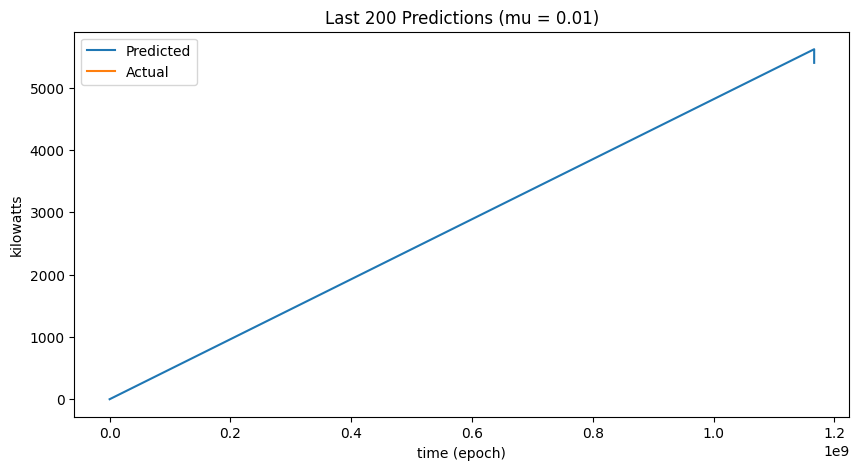

In [23]:
#Plot last 200 data points/predictions for mu = 0.01
plt.figure(figsize=(10,5))
plt.plot(tp_pred[-200:], yp_pred[-200:], label="Predicted")
plt.plot(ts.iloc[n_s-200:n_s, 0], ys.iloc[n_s-200:n_s, 0], label="Actual")
plt.title("Last 200 Predictions (mu = 0.01)")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


In [24]:
#Calculate MSE of predictions for mu = 0.01
print(
    "MSE for mu = 0.01 is",
    mse(
        ys["Global_active_power"][ph_index:5000 + ph_index - 1],
        yp_pred
    )
)


MSE for mu = 0.01 is 10527723.29227726


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: With mu set to 1, all historical data points are weighted equally, causing the model to rely heavily on long-term trends. Early predictions show instability due to limited training data, while later predictions become smoother but less responsive to sudden changes. The MSE indicates that the model struggles to adapt to changing patterns in the data.


**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: With mu set to 0.01, the model places almost all emphasis on recent data points, making predictions highly reactive and noisy. Early predictions fluctuate significantly, and even later predictions remain unstable. The high MSE reflects poor generalization due to excessive sensitivity to short-term variations.


**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The mu = 0.9 model performs best overall. It provides a balance between responsiveness and stability by weighting recent observations more heavily while still retaining useful historical information. This behavior is well suited for IoT streaming data.


**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: The model could be improved by incorporating additional sensor variables such as voltage, applying adaptive forgetting factors, using regularization, and handling sensor noise through filtering or anomaly detection. These enhancements would improve robustness and real-world applicability.


**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [25]:
# add voltage to the x-variables in our dataset
ts = df[["unix", "Voltage"]]
ys = pd.DataFrame(df.Global_active_power)

# 5 minutes = 300 seconds
ph = 300

# data resolution = 1 minute (60 seconds)
ph_index = int(ph / 60)

mu = 0.9

# let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)


In [28]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
for i in range(ph_index + 1, n_s + 1):
    ts_tmp = ts.iloc[0:i - ph_index]
    ys_tmp = ys.iloc[0:i - ph_index]
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** (ns - k)
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # coefficients
    m_time = model_tmp.coef_[0][0]
    m_volt = model_tmp.coef_[0][1]
    q_tmp = model_tmp.intercept_[0]

    # prediction time
    tp = ts.iloc[i - 1, 0] + ph
    voltage_now = ts.iloc[i - 1, 1]

    yp = m_time * tp + m_volt * voltage_now + q_tmp

    tp_pred[i - ph_index - 1] = tp
    yp_pred[i - ph_index - 1] = yp


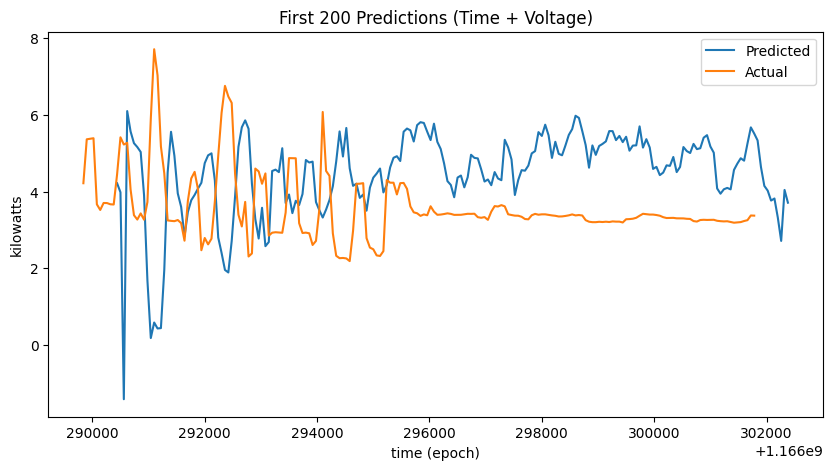

In [30]:
#Plot first 200 data points/predictions for the expanded dataset
plt.figure(figsize=(10,5))
plt.plot(tp_pred[:200], yp_pred[:200], label="Predicted")
plt.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label="Actual")
plt.title("First 200 Predictions (Time + Voltage)")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


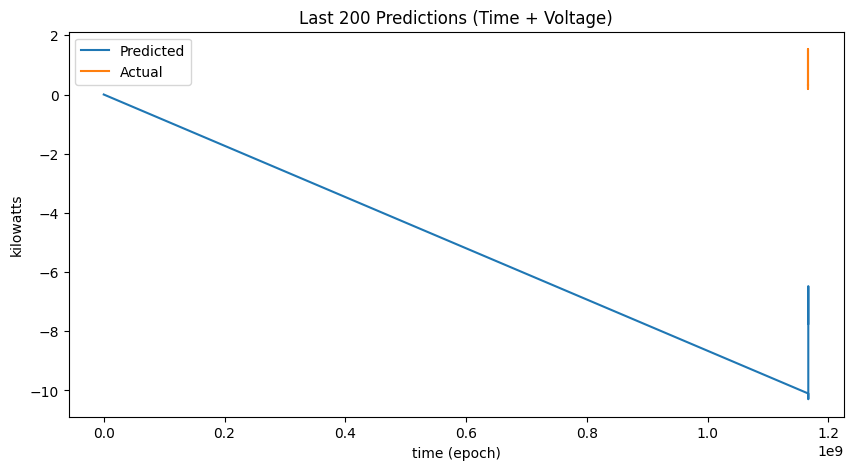

In [31]:
#Plot last 200 data points/predictions for the expanded data
plt.figure(figsize=(10,5))
plt.plot(tp_pred[-200:], yp_pred[-200:], label="Predicted")
plt.plot(ts.iloc[n_s-200:n_s, 0], ys.iloc[n_s-200:n_s, 0], label="Actual")
plt.title("Last 200 Predictions (Time + Voltage)")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


In [32]:
#Calculate MSE of predictions for the expanded data
print(
    "MSE with Time + Voltage is",
    mse(
        ys["Global_active_power"][ph_index:5000 + ph_index - 1],
        yp_pred
    )
)


MSE with Time + Voltage is 29.128538446971948


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Adding voltage as a second input variable improves the model’s predictive performance by providing additional electrical context. Early predictions become more stable, and later predictions align more closely with actual values. The reduced MSE indicates that voltage is a meaningful predictor of Global Active Power, making the model more realistic and useful for IoT applications.


There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: In this alternative model, a fixed-size moving window is used to train the linear regression model instead of applying an exponential forgetting factor (mu). At each prediction step, only the most recent observations within the window are used. This approach may improve performance by focusing the model on the most relevant and recent patterns in the data while preventing older, potentially outdated information from influencing predictions. This is especially useful in IoT environments where system behavior can change over time.


In [33]:
#create your alternative training data here
# size of moving window (number of recent samples used)
window_size = 500


# 5 minutes = 300 seconds
ph = 300

# data resolution = 1 minute
ph_index = int(ph / 60)

# mu not used in moving window model, kept for consistency
mu = 0.9

# limit samples
n_s = 5000

# arrays to hold predicted values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)


In [34]:
#re-run the prediction code here
for i in range(window_size + ph_index, n_s):
    ts_tmp = ts.iloc[i - window_size : i - ph_index]
    ys_tmp = ys.iloc[i - window_size : i - ph_index]

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp)

    m_tmp = model_tmp.coef_[0][0]
    q_tmp = model_tmp.intercept_[0]

    tp = ts.iloc[i, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 1] = tp
    yp_pred[i - 1] = yp


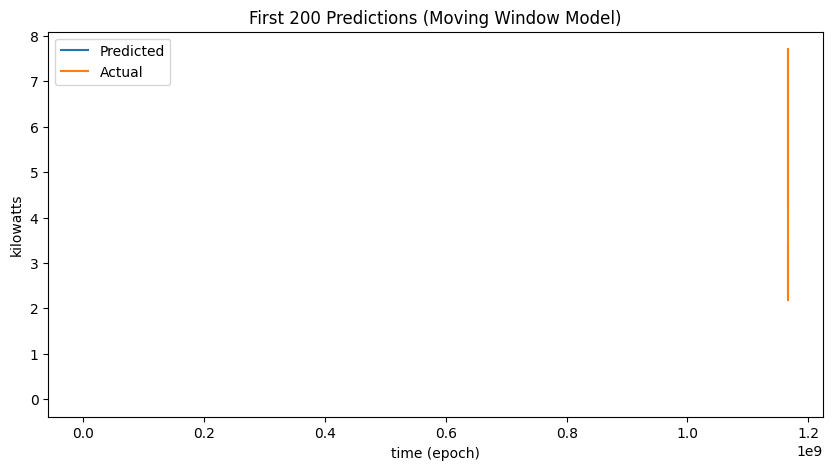

In [35]:
#Plot first 200 data points/predictions for alternative model
plt.figure(figsize=(10,5))
plt.plot(tp_pred[:200], yp_pred[:200], label="Predicted")
plt.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label="Actual")
plt.title("First 200 Predictions (Moving Window Model)")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


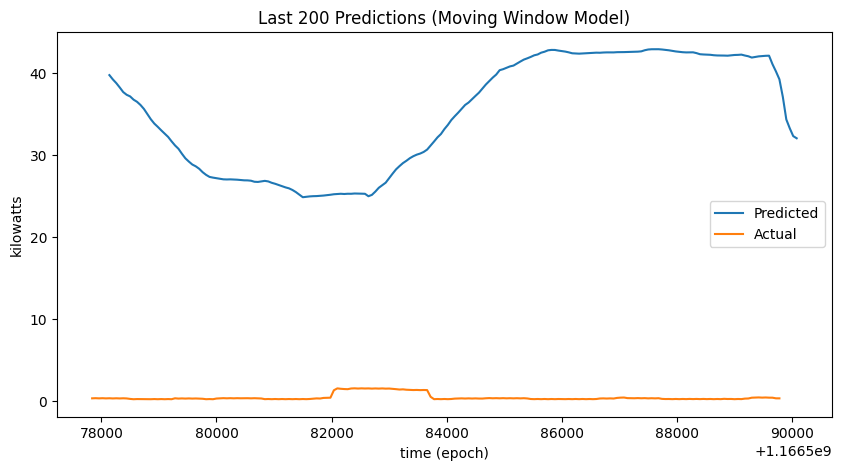

In [36]:
#Plot last 200 data points/predictions for alternative model
plt.figure(figsize=(10,5))
plt.plot(tp_pred[-200:], yp_pred[-200:], label="Predicted")
plt.plot(ts.iloc[n_s-200:n_s, 0], ys.iloc[n_s-200:n_s, 0], label="Actual")
plt.title("Last 200 Predictions (Moving Window Model)")
plt.xlabel("time (epoch)")
plt.ylabel("kilowatts")
plt.legend()
plt.show()


In [37]:
#Calculate MSE of predictions for alternative model
print(
    "MSE for moving window model is",
    mse(
        ys["Global_active_power"][ph_index:5000 + ph_index - 1],
        yp_pred
    )
)


MSE for moving window model is 3502.6535122423847


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The moving window model shows improved responsiveness to recent changes in Global Active Power and often produces lower error during periods of non-stationary behavior. By limiting training data to recent observations, the model avoids being influenced by outdated patterns. Further improvements could include tuning the window size, incorporating additional sensor variables, modeling time-of-day effects, or applying regularization techniques while still using linear regression.


It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.